# Exploring the Ames Housing dataset

## Loading the Ames Housing dataset into a data frame

In [34]:
import numpy as np
import pandas as pd

In [1]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

# Use the read_csv function with sep='\t' to read a tab-delimited file
df = pd.read_csv('AmesHousing.txt', sep='\t', usecols=columns)

# Review the top 5 rows
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
# remove rows that contain missing values

df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

# Split the data into train and test

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

# Separate the target variable

In [54]:
train_y = train['SalePrice']
test_y = test['SalePrice']

train_inputs = train.drop(['SalePrice'], axis=1)
test_inputs = test.drop(['SalePrice'], axis=1)

In [11]:
train_inputs['Gr Liv Area'].describe()

count    2050.000000
mean     1496.387317
std       518.243605
min       407.000000
25%      1114.000000
50%      1430.500000
75%      1733.000000
max      5642.000000
Name: Gr Liv Area, dtype: float64

<Axes: >

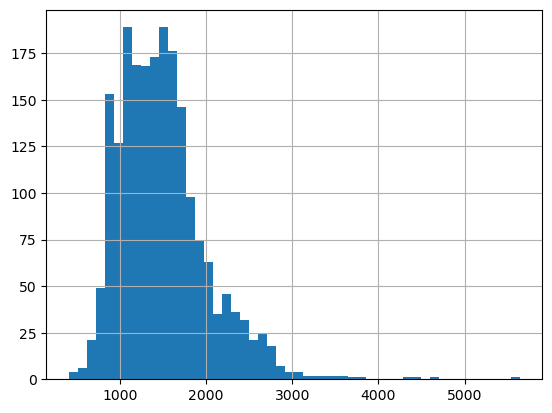

In [13]:
train_inputs['Gr Liv Area'].hist(bins=50)

## Create a new ordinal column: convert the Gr Liv Area to ordinal values

In [28]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['GrLivArea_binned'] = pd.cut(df1['Gr Liv Area'],
                                       bins=[0,1000,1300,1600,2000,10000],  #bins=[exclusive, inclusive]
                                       labels=False, 
                                       include_lowest=True,
                                       ordered=True)

    return df1[['GrLivArea_binned']]

In [29]:
new_col(train_set)

,GrLivArea_binned
2435,2
423,4
1095,2
1925,0
275,3
...,...
2244,1
860,0
1274,0
1154,0


In [30]:
#Check the new distribution

new_col(train_set).value_counts()

GrLivArea_binned
2                   529
3                   493
1                   462
0                   302
4                   264
Name: count, dtype: int64

array([[<Axes: title={'center': 'GrLivArea_binned'}>]], dtype=object)

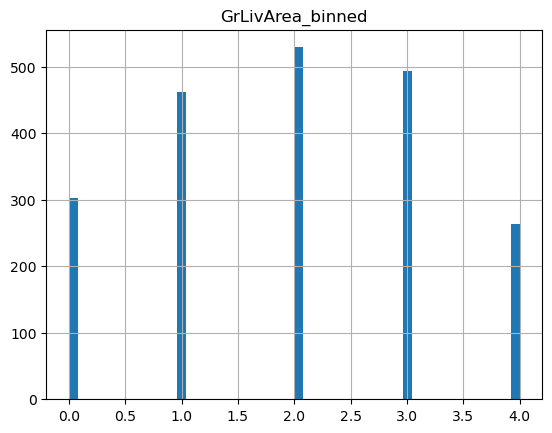

In [31]:
new_col(train_set).hist(bins=50)

# Identify the numeric, binary, and categorical columns

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [32]:
train_inputs.dtypes

Overall Qual       int64
Overall Cond       int64
Total Bsmt SF    float64
Central Air        int64
Gr Liv Area        int64
dtype: object

In [36]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [37]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['Central Air']

In [38]:
# We need to remove the binary columns from numerical columns.
for col in binary_columns:
    numeric_columns.remove(col)

In [39]:
binary_columns

['Central Air']

In [40]:
numeric_columns

['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Gr Liv Area']

In [41]:
categorical_columns

[]

In [47]:
feat_eng_columns = ['Gr Liv Area']

In [42]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [43]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [44]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [45]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [48]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='drop')

In [49]:
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-0.77288805,  0.41083209, -0.21956923, -0.75154294,  1.        ,
        -0.7478444 ],
       [-0.77288805,  0.41083209,  0.10006906, -0.78628412,  1.        ,
        -0.7478444 ],
       [ 0.64557257, -0.50064603, -0.37710524,  0.42386682,  1.        ,
         0.8133379 ],
       ...,
       [-0.06365774,  1.3223102 , -0.14194279,  0.48948903,  1.        ,
         0.8133379 ],
       [-0.77288805,  0.41083209, -2.38626017, -1.32863246,  0.        ,
        -1.52843555],
       [-0.06365774, -0.50064603,  0.536147  ,  1.92738767,  1.        ,
         1.59392905]])

In [50]:
train_x.shape

(2050, 6)

In [51]:
test_x = preprocessor.transform(test_inputs)

test_x

array([[-0.77288805, -2.32360226, -0.08943078, -0.94647954,  1.        ,
        -0.7478444 ],
       [-0.77288805,  2.23378832, -0.41363533, -1.1433462 ,  1.        ,
        -1.52843555],
       [-0.06365774, -0.50064603,  0.15714732, -0.73803249,  1.        ,
        -0.7478444 ],
       ...,
       [-1.48211836,  1.3223102 ,  0.34436403, -0.57976713,  1.        ,
        -0.7478444 ],
       [ 0.64557257, -0.50064603,  0.98135747,  1.60699683,  1.        ,
         1.59392905],
       [ 1.35480288, -0.50064603,  1.59095334,  0.47404851,  1.        ,
         0.8133379 ]])

In [52]:
test_x.shape

(879, 6)

## Calculate the baseline

In [55]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_x, train_y)

DummyRegressor()

In [56]:
from sklearn.metrics import mean_squared_error
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)
baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)
baseline_train_rmse = np.sqrt(baseline_train_mse)
print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 80902.21774636394


In [57]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)
baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)
baseline_test_rmse = np.sqrt(baseline_test_mse)
print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 77395.39859898292


In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor

# Define the Voting Regressor parameters
dtree_reg = DecisionTreeRegressor(max_depth=5)
svm_reg = SVR(kernel="rbf", C=1, epsilon=0.1, gamma=1) 
rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1) 

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), 
                        ('svr', svm_reg), 
                        ('rnd', rnd_reg)])

voting_reg.fit(train_x, train_y)

VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=5)),
                            ('svr', SVR(C=1, gamma=1)),
                            ('rnd',
                             RandomForestRegressor(max_depth=5,
                                                   n_estimators=500,
                                                   n_jobs=-1))])

In [61]:
#Train RMSE
train_pred = voting_reg.predict(train_x)
train_mse = mean_squared_error(train_y, train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Test RMSE: 195312.54933647992


In [62]:
#Test RMSE
test_pred = voting_reg.predict(test_x)
test_mse = mean_squared_error(test_y, test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 195349.42941521064


In [68]:
# Inspect results each classifier
for reg in (dtree_reg, svm_reg, rnd_reg, voting_reg):
    reg.fit(train_x, train_y)
    test_y_pred = reg.predict(test_x)
    print(reg.__class__.__name__, 'Test rmse=', np.sqrt(mean_squared_error(test_y, test_y_pred)))

DecisionTreeRegressor Test rmse= 34351.66628160074
SVR Test rmse= 80391.02700226787
RandomForestRegressor Test rmse= 29750.93680857788
VotingRegressor Test rmse= 39816.43544013553


In [69]:
from sklearn.preprocessing import PolynomialFeatures
# Create second degree terms and interaction terms
poly_features = PolynomialFeatures(degree=2).fit(train_x)
train_x_poly = poly_features.transform(train_x)
test_x_poly = poly_features.transform(test_x)

In [70]:
train_x_poly.shape

(2050, 28)

In [71]:
from sklearn.linear_model import SGDRegressor 
elastic_net = SGDRegressor(max_iter=1000, penalty='elasticnet', l1_ratio=0.5, alpha = 95, 
                          eta0=0.01)

elastic_net.fit(train_x_poly, train_y)

SGDRegressor(alpha=95, l1_ratio=0.5, penalty='elasticnet')

In [72]:
#Train RMSE
reg_train_pred = elastic_net.predict(train_x_poly)
train_mse = mean_squared_error(train_y, reg_train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 68502.70737693513


In [73]:
#Test RMSE
reg_test_pred = elastic_net.predict(test_x_poly)
test_mse = mean_squared_error (test_y, reg_test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 66945.32921486521


In [74]:
# eta0 = learning rate
# penalty = regularization term
# max_iter = number of passes over training data (i.e., epochs)

sgd_reg = SGDRegressor(max_iter=100, penalty=None, eta0=0.01) 
sgd_reg.fit(train_x, train_y)

SGDRegressor(max_iter=100, penalty=None)

In [75]:
#Train RMSE
reg_train_pred = sgd_reg.predict(train_x)
train_mse = mean_squared_error(train_y, reg_train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 38991.416348416846


In [76]:
#Test RMSE
reg_test_pred = sgd_reg.predict(test_x)
test_mse = mean_squared_error (test_y, reg_test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 39019.18394716388


## Visualizing the important characteristics of a dataset

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

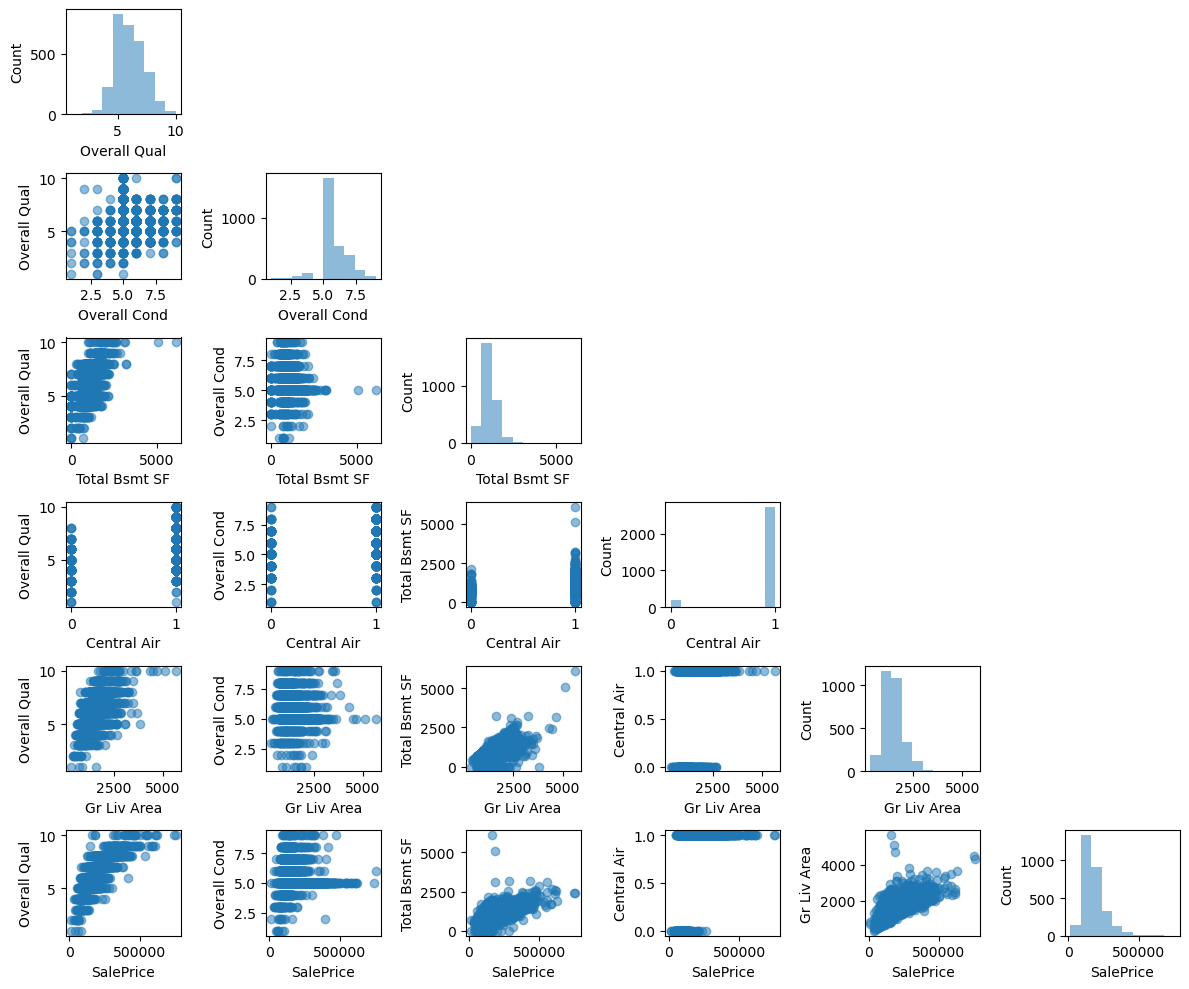

In [12]:
scatterplotmatrix(df.values, figsize=(12, 10), 
                  names=df.columns, alpha=0.5)
plt.tight_layout()
#plt.savefig('figures/09_04.png', dpi=300)
plt.show()

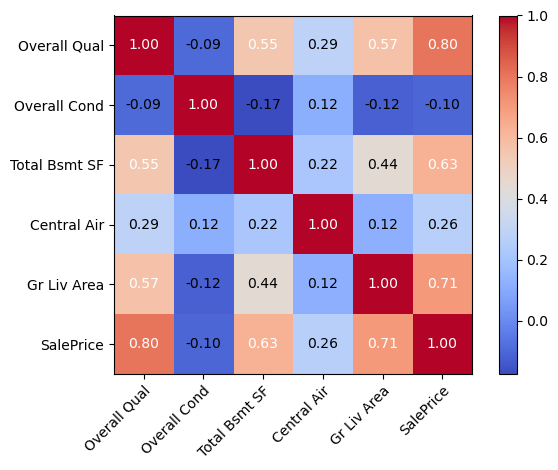

In [13]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns, cmap='coolwarm')

plt.tight_layout()
#plt.savefig('figures/09_05.png', dpi=300)
plt.show()

# Implementing an ordinary least squares linear regression model

## Solving regression for regression parameters with gradient descent

In [14]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [15]:
X = df[['Gr Liv Area']].values

y = df['SalePrice'].values

In [16]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [17]:
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

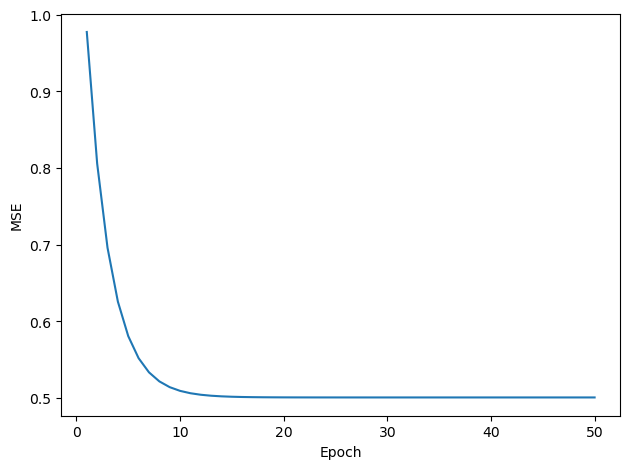

In [18]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

In [19]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

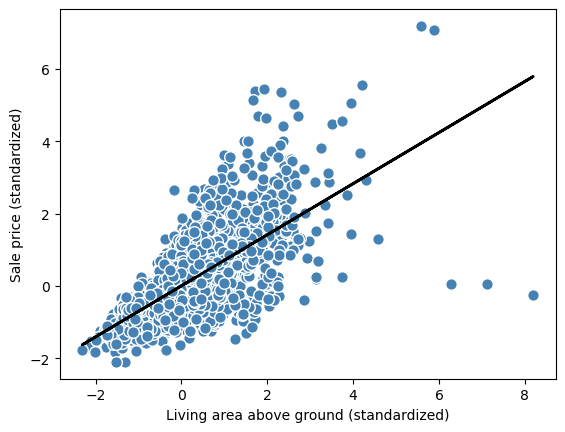

In [20]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

#plt.savefig('figures/09_07.png', dpi=300)
plt.show()

In [21]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


In [22]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


## Estimating the coefficient of a regression model via scikit-learn

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


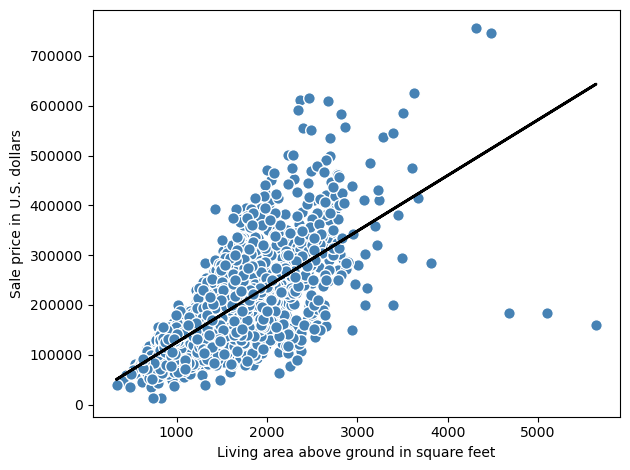

In [25]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_08.png', dpi=300)
plt.show()

**Normal Equations** alternative:

In [26]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


# Fitting a robust regression model using RANSAC

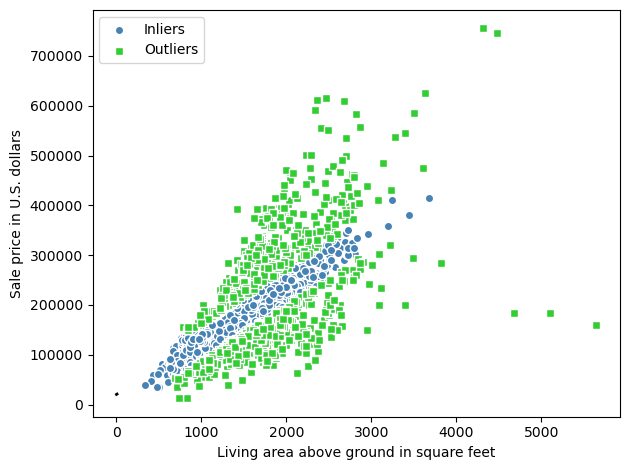

In [27]:
from sklearn.linear_model import RANSACRegressor


ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=None, # default 
                         random_state=123)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_09.png', dpi=300)
plt.show()

In [28]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [29]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))
    
median_absolute_deviation(y)

37000.0

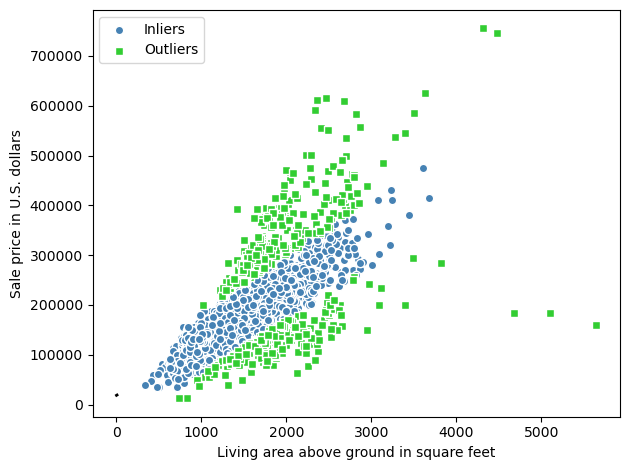

In [30]:
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=65000, # default 
                         random_state=123)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_10.png', dpi=300)
plt.show()

In [31]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 105.631
Intercept: 18314.587


# Evaluating the performance of linear regression models

In [32]:
from sklearn.model_selection import train_test_split


target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [33]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

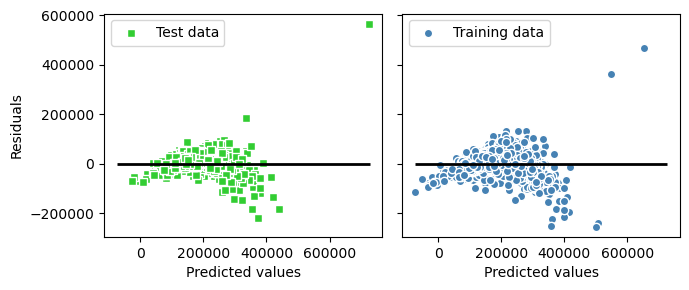

In [34]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_11.png', dpi=300)
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error


mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)


print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [36]:
from sklearn.metrics import mean_absolute_error


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


In [37]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75


In [38]:
coefs=slr.coef_
for feature, coef in zip(features, coefs):
    print(f"{feature}: {coef}")

Overall Qual: 26251.464057657246
Overall Cond: 804.9065614898744
Total Bsmt SF: 41.94429277606437
Central Air: 11380.692130826501
Gr Liv Area: 55.67824639736455


# Using regularized methods for regression

In [39]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [40]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test: 1516576825.348
R^2 train: 0.769, 0.752


Ridge regression:

In [41]:
from sklearn.linear_model import Ridge


ridge = Ridge(alpha=1.0)

LASSO regression:

In [42]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1.0)

Elastic Net regression:

In [43]:
from sklearn.linear_model import ElasticNet


elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Turning a linear regression model into a curve - polynomial regression

In [44]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [45]:
from sklearn.preprocessing import PolynomialFeatures


lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

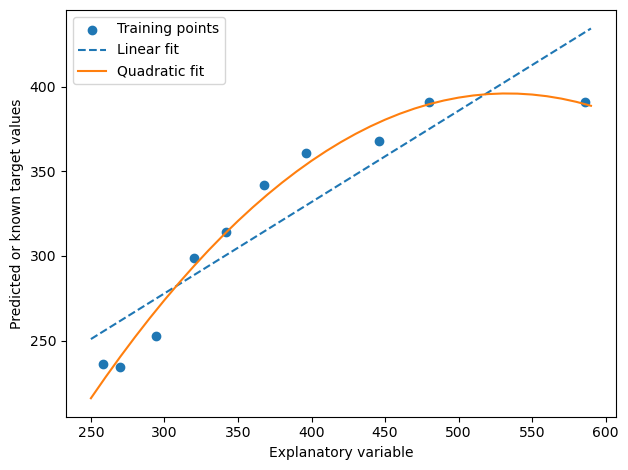

In [46]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_12.png', dpi=300)
plt.show()

In [47]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [48]:
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Ames Housing dataset

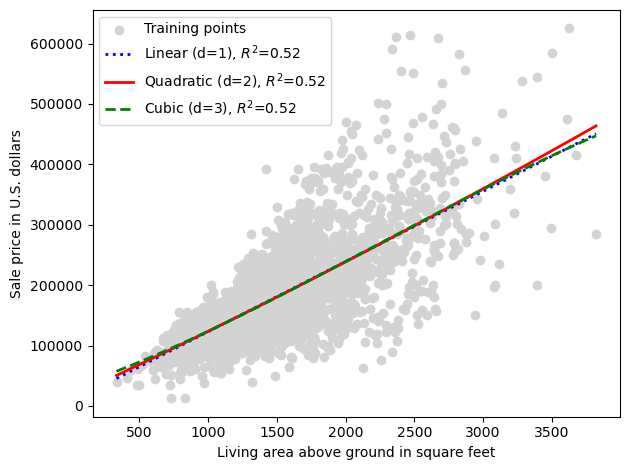

In [49]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('09_13.png', dpi=300)
plt.show()

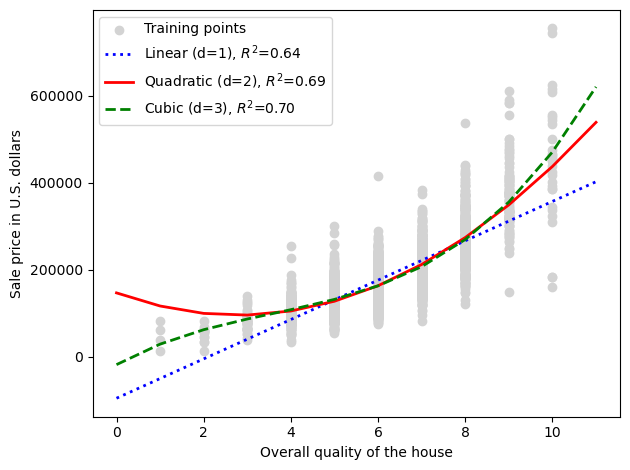

In [50]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('09_14.png', dpi=300)
plt.show()

# Dealing with nonlinear relationships using random forests

## Decision tree regression

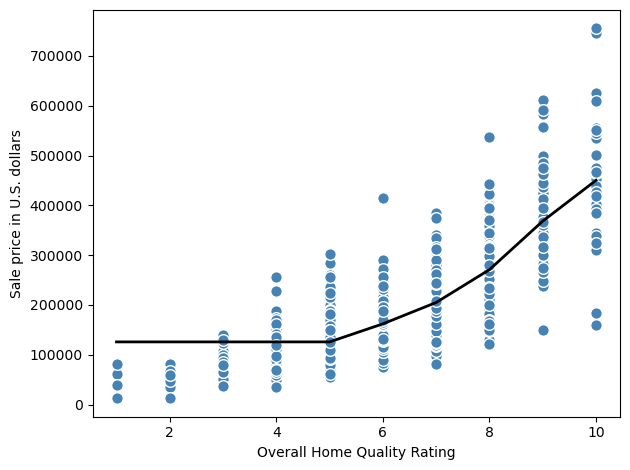

In [51]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Overall Qual']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Overall Home Quality Rating')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [52]:
tree_r2 = r2_score(y, tree.predict(X))
#tree_r2
print(f'R^2: {tree_r2:.2f}')

R^2: 0.69


## Random forest regression

In [53]:
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [54]:
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


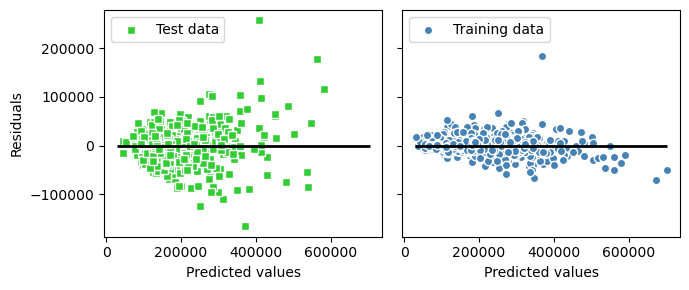

In [55]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_16.png', dpi=300)
plt.show()

In [56]:
import pickle

In [57]:
file = 'model.sav'
pickle.dump(forest, open(file, 'wb'))

In [58]:
feature_imp = pd.DataFrame(
{'importance':forest.feature_importances_},
index=features)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Overall Qual,0.639535
Gr Liv Area,0.201718
Total Bsmt SF,0.131774
Overall Cond,0.018423
Central Air,0.008549


In [66]:
pip show seaborn

Name: seaborn
Version: 0.11.2
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@gmail.com
License: BSD (3-clause)
Location: c:\users\chadu\anaconda3\lib\site-packages
Requires: matplotlib, numpy, pandas, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [70]:
input_data=pd.DataFrame({
    'Overall Qual':[5],
    'Overall Cond':[5],
    'Gr Liv Area':[1500],
    'Central Air':[1],
    'Total Bsmt SF':[1000]
})

In [68]:
model = pickle.load(open('model.sav', 'rb'))

In [71]:
pred = model.predict(input_data)
print(f"Predicted Sale Price: ${pred[0]:,.2f}")

Predicted Sale Price: $138,208.34


C:\Users\chadu\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
